# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /Users/pedro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64
27.51 % of users only see one article


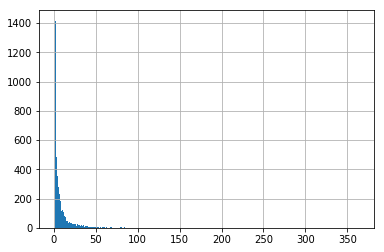

In [3]:
views_by_user = df.groupby('email').count().article_id
print(views_by_user.describe())
one_view_users = views_by_user[views_by_user == 1].shape[0]/views_by_user.shape[0] * 100
print('{:.2f} % of users only see one article'.format(one_view_users))
views_by_user.hist(bins=np.arange(views_by_user.min(), views_by_user.max()+1, 1));

There are a total of 5148 different users, 27 % of users only interact with one article and 50% of them interact with 3 or less articles. There are at least one individual that interacted with 364 articles, the maximum in our dataset.

count    714.000000
mean      64.392157
std      109.161462
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: email, dtype: float64
2.52 % of articles were only seen once
The most common number of views is 2 representing 8.96 % of the articles


(0, 30)

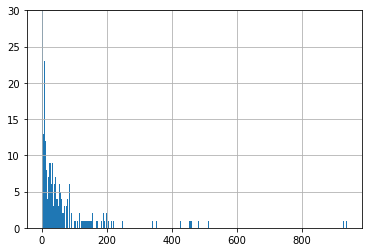

In [4]:
views_per_article = df.groupby('article_id').count().email
print(views_per_article.describe())
one_view_articles = views_per_article[views_per_article == 1].shape[0]/views_per_article.shape[0] * 100
print('{:.2f} % of articles were only seen once'.format(one_view_articles))
mode = views_per_article.mode().values[0]
mode_view_articles = views_per_article[views_per_article == mode].shape[0]/views_per_article.shape[0] * 100
print('The most common number of views is {} representing {:.2f} % of the articles'.format(mode, mode_view_articles))
views_per_article.hist(bins=np.arange(views_per_article.min(), views_per_article.max()+1, 1));
plt.ylim([0,30])

There is a total of 714 articles, following what it seems to be a lognormal distribution, many articles have only been seen once or twice (above 10% of articles). 50% of articles have been seen 8 times of less. The distribution has a long tail with one article reaching 937 views, however there seems to be a gap, there are 2 articles on the 900 region and then in drops to the 500 view region. It would suggest a some sort of "viral" behaviour.

In [5]:
median_val = df.groupby('email').count().article_id.median()
print('50% of individuals interact with {:.0f} articles or fewer.'.format(median_val))
max_views_by_user = df.groupby('email').count().max().values[0]
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
for i, s in df_content.iteritems():
    print('feature "{}" has {} duplicates'.format(i, s.duplicated().sum()))
df_content[df_content.doc_full_name.duplicated(keep=False)].sort_values('doc_full_name')

feature "doc_body" has 19 duplicates
feature "doc_description" has 33 duplicates
feature "doc_full_name" has 5 duplicates
feature "doc_status" has 1055 duplicates
feature "article_id" has 5 duplicates


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398


We see that there are only 5 duplicates on doc_full_name and article_id. There are more duplicates on doc_description since this field can encompass several articles without problem. There are however 19 duplicates on doc_body which is more that the article_id. Let us remove the duplicates on article_id to begin with and see how our data looks like

In [7]:
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

In [8]:
for i, s in df_content.iteritems():
    print('feature "{}" has {} duplicates'.format(i, s.duplicated().sum()))
df_content[df_content.doc_body.duplicated(keep=False)].sort_values('doc_body')

feature "doc_body" has 19 duplicates
feature "doc_description" has 31 duplicates
feature "doc_full_name" has 0 duplicates
feature "doc_status" has 1050 duplicates
feature "article_id" has 0 duplicates


,doc_body,doc_description,doc_full_name,doc_status,article_id
244,* Select a country/region: United States\r\n\r...,"Data exploration and analysis is a repetitive,...",Notebooks: A power tool for data scientists,Live,244
474,* Select a country/region: United States\r\n\r...,Machine learning is changing not only how we ...,Intelligent applications - Apache Spark,Live,473
564,Cheat sheet,The RStudio IDE is the most popular integrated...,RStudio IDE Cheat Sheet,Live,563
678,Cheat sheet,The devtools package makes it easy to build yo...,Package Development with devtools Cheat Sheet,Live,677
892,Need to report the video?\r\n\r\nSign in to re...,Video tutorial showing the complete creation o...,Mobile App Webinar Demo,Live,889
997,Need to report the video?\r\n\r\nSign in to re...,Using Cloudant and MobileFirst services on Blu...,Building a MobileFirst App on IBM Bluemix,Live,992
33,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,Analytics and visualization often go hand-in-h...,Using Brunel in IPython/Jupyter Notebooks,Live,33
369,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,After shoveling the driveway several times and...,Snowzilla!,Live,368
885,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,How to create a blog entry using Brunel in a f...,Blogging With Brunel,Live,882
1020,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,The two main new features of Brunel 0.8 are an...,Enhanced Color mapping,Live,1015


Most of the duplicates in content are because there are NaN or as in doc_description the are standard texts used like: "Cheat Sheet"

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [9]:
unique_interaction_articles = df.article_id.unique()
unique_articles = unique_interaction_articles.shape[0]
print('There are {} unique articles that have been interacted with'.format(unique_articles))
unique_IBM_articles = df_content.article_id.unique()
total_articles = unique_IBM_articles.shape[0]
print('There is a total of {} articles in the IBM platform.'.format(total_articles))
interactions_in_platform = np.isin(unique_interaction_articles,df_content.article_id.values).sum()
in_platform =  interactions_in_platform/unique_IBM_articles.shape[0] * 100
print('{:.2f} % of interaction articles are in IBM platform'.format(in_platform))
unique_emails = df.email.unique().shape[0] - 1
print('There are {} unique users emails'.format(unique_emails))
interactions = df.shape[0]
print('There is a total on {} interactions in our dataset'.format(interactions))

There are 714 unique articles that have been interacted with
There is a total of 1051 articles in the IBM platform.
41.58 % of interaction articles are in IBM platform
There are 5148 unique users emails
There is a total on 45993 interactions in our dataset


In [10]:
unique_articles = unique_articles # The number of unique articles that have at least one interaction
total_articles = total_articles # The number of unique articles on the IBM platform
unique_users = unique_emails# The number of unique users
user_article_interactions = interactions# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [11]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.groupby('article_id').count().sort_values('email').email.index[-1])

# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby('article_id').count().sort_values('email').email.iloc[-1]


In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [14]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('title').count().article_id.sort_values(ascending=False).iloc[:n].index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    top_articles = list(df.groupby('article_id').count().title.sort_values(ascending=False).iloc[:n].index)
 
    return top_articles # Return the top article ids

In [15]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [16]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [17]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    aux_df = df.copy(deep=True).drop_duplicates(keep='first')
    aux_df['value'] = 1
    user_item = aux_df.pivot(index='user_id',columns='article_id', values='value').fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [18]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [19]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_item_matrix = user_item.values
    user_vector = user_item.loc[user_id, :].values
    similarity_vector = user_item_matrix.dot(user_vector)
    
    # sort by similarity
    similarity_series = pd.Series(similarity_vector, index=user_item.index)
    similarity_series.drop(user_id, inplace=True)
    most_similar_users = list(similarity_series.sort_values(ascending=False).index)

       
    return most_similar_users 
        

In [20]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [21]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    id_title = df[['article_id', 'title']].drop_duplicates(keep='first')
    article_names = list(id_title[id_title.article_id.isin(article_ids)].title)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user = user_item.loc[user_id, :]
    article_ids = list(user[user == 1].index.astype(str))
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    seen_ids, _ = get_user_articles(user_id)
    recs = []
    total_recs = 0
    for similar_user in similar_users:
        candidate_ids, candidate_titles = get_user_articles(similar_user)
        new_recs_ids = [article_id for article_id in candidate_ids if article_id not in seen_ids]
        total_recs += len(new_recs_ids)
        
        if total_recs > m:
            remaining_recs = m - len(recs)
            for i in range(remaining_recs):
                recs.append(new_recs_ids[i])
            break
        else:
            recs += new_recs_ids
            seen_ids += new_recs_ids
            
    return recs   

In [22]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [23]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [24]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    user_item_matrix = user_item.values
    user_vector = user_item.loc[user_id, :].values
    similarity_vector = user_item_matrix.dot(user_vector)

    # user interactions
    user_interactions = df.groupby('user_id').count().title
    user_interactions.name = 'num_interactions'
    user_interactions = user_interactions.to_frame()

    # user similarity
    user_similarities = pd.Series(similarity_vector, index=user_item.index, name = 'similarity').to_frame()

    # sorting dataframe
    sorting_df = pd.concat([user_interactions, user_similarities], axis=1)
    sorting_df.drop(user_id, inplace=True)
    sorting_df.reset_index(inplace=True)
    sorting_df.rename(columns = {'user_id':'neighbor_id'}, inplace=True)
    sorting_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    neighbors_df = sorting_df
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    df - (pandas dataframe) df as defined at the top of the notebook 
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    similar_users_df = get_top_sorted_users(user_id)
    similar_users =  list(similar_users_df.neighbor_id.values)
    seen_ids, _ = get_user_articles(user_id)
    recs = []
    total_recs = 0
    article_interactions = df.groupby('article_id').count().user_id
    article_interactions.name = 'num_interactions'
    article_interactions.index = article_interactions.index.astype(str)
    
    for similar_user in similar_users:
        candidate_ids, candidate_titles = get_user_articles(similar_user)
        new_recs_ids = [article_id for article_id in candidate_ids if article_id not in seen_ids]
        total_recs += len(new_recs_ids)
        new_recs_ids = list(article_interactions[new_recs_ids].sort_values(ascending=False).index)
        
        if total_recs > m:
            remaining_recs = m - len(recs)
            for i in range(remaining_recs):
                recs.append(new_recs_ids[i])
            break
        else:
            recs += new_recs_ids
            seen_ids += new_recs_ids
            
    return recs, get_article_names(recs)

In [25]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [26]:
### Tests with a dictionary of results
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9]

In [27]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

With new users we face the __cold start__ problem. In these cases we cannot use collaborative filtering since we lack the user interactions information. We may turn to knowledge based recommendations, in our case we could use `get_top_articles()`.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [28]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here
new_user_recs = [str(art_id) for art_id in new_user_recs]

In [29]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

As we saw in the exploratory phase of this notebook, not all the articles interacted with (article ids is df) are present in the IMB content dataframe (df_content). It is therefore very difficult to recommend based on content since we do not have information about many of the articles read by users.
I have chosen to complete df_content with the title information from df. The doc_full_name field in df_content corresponds to the title field in title. 
First I will create a new dataframe joining both dataframes.

In [30]:
missing_articles = np.setdiff1d(df.article_id.unique(), df_content.article_id.unique())
extra_articles = df.drop_duplicates('article_id', 
                                    keep='first')[df.article_id.isin(missing_articles)][['article_id', 'title']]
extra_articles.rename(columns={'title':'doc_full_name'}, inplace=True)
extra_articles.sort_values('article_id', inplace=True)
extra_articles.reset_index(drop=True, inplace=True)
df_content_extended = pd.concat([df_content, extra_articles], ignore_index=True, sort=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


df_content_extended has now all the titles of all the articles interacted with.

Since that is the only complete field I have I will base my recommendations exclusively on the title of the articles.

In the following cell I create a matrix of TF-IDF features from all the article titles. this matrix will be used to calculate similarity between article titles very much in the same way as before between users. 

In [31]:
def tokenize(text):
    """tokenizer function that takes a text and return a list of tokens (strings)"""
    text_lower = text.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    lem = WordNetLemmatizer()
    words = tokenizer.tokenize(text_lower)
    words = [word for word in words if word not in stopwords.words('english')]
    words = [lem.lemmatize(word) for word in words]
    return words

corpus = df_content_extended.doc_full_name
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus)
name_by_words = X.toarray()
name_by_words = pd.DataFrame(name_by_words, index=df_content_extended.article_id, 
                             columns = list(vectorizer.vocabulary_))

In [32]:
def calculate_content_similarity(article_id, name_by_words=name_by_words):
    """
    INPUT:
    - article_id(int): article id to calculate similarities
    - name_by_words(dataframe): dataframe with rows eachthe articles and columns tokens. 
                                The values are the TF-IDF features
    OUTPUT:
    - similarities(pd.Series): series with the similiraties and index each article id.
    """
    article_vector = name_by_words.loc[article_id, :].values
    name_by_words_matrix = name_by_words.values
    similarity = name_by_words_matrix.dot(article_vector)
    return pd.Series(similarity, index=name_by_words.index)

In [33]:
def make_content_recs(user_id, m=10, name_by_words=name_by_words):
    '''
    INPUT:
    - user_id(int): user id to make recommendations to.
    - m (int): number of recommendations to make
    - name_by_words(dataframe): dataframe with rows eachthe articles and columns tokens. 
                                The values are the TF-IDF features
    OUTPUT:
    - recs_ids(list): list of article IDs recommended to that user.
    
    Notes: if the user does not exist it will return a list of the top articles by view
    
    '''
    try:
        article_ids, _ = get_user_articles(user_id)
        articles_similarities = []
        articles_to_drop = []
        for article_id in article_ids:
            article_id = float(article_id)
            article_similarities = calculate_content_similarity(article_id).to_frame()
            articles_similarities.append(article_similarities)
            articles_to_drop.append(article_id)
        sum_of_similarities = pd.concat(articles_similarities, axis=1).sum(axis=1).drop(articles_to_drop)
        rec_ids = list(sum_of_similarities.sort_values(ascending=False).iloc[:m].index)
    except KeyError:
        rec_ids = get_top_article_ids(m)
    return rec_ids

In [34]:
#Example of recommendation
make_content_recs(1000, m=10)

[671.0, 809.0, 161.0, 1427.0, 893.0, 313.0, 202.0, 1298.0, 1028.0, 80.0]

In [35]:
# get_article_names needs to be updated to look in the new extended df_Content 
def get_article_names(article_ids):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    id_title = df_content_extended[['article_id', 'doc_full_name']].drop_duplicates(keep='first')
    article_names = list(id_title[id_title.article_id.isin(article_ids)].doc_full_name)
    
    return article_names 


In [36]:
get_article_names(make_content_recs(140, m=10))

['Top 10 Machine Learning Use Cases: Part 1',
 '8 ways to turn data into value with Apache Spark machine learning',
 'Use the Machine Learning Library in Spark',
 'What is machine learning?',
 'What is Spark?',
 'Apache Spark Analytics',
 'The power of machine learning in Spark',
 'Use the Machine Learning Library in IBM Analytics for Apache Spark',
 'Load Cloudant Data in Apache Spark Using a Python Notebook',
 'apache spark lab, part 2: querying data']

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

The recommender bases its recommendations of the similarity of other article titles to the titles read by a user.
It follows the following steps:

* Given a user, the recommender loops through the articles read by that user.
* For each article read, it calculates the similarity of the article's title to the rest of available articles. 
* Similarity is calculated by the dot product of the TF-IDF features of articles.
* After, these similarities are summed in a total similarity score and sorted, the top m values are returned.



`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [37]:
# make recommendations for a brand new user
new_user_recs = make_content_recs(3000, m=5)

# make a recommendations for a user who only has interacted with article id '1427.0'
# My recommender works on users not article ids, the above case should be included in the events dataframe(df)
# Here is another example of recommendation for a user
get_article_names(make_content_recs(17, m=10))


['Python Machine Learning: Scikit-Learn Tutorial',
 'Use the Machine Learning Library in Spark',
 'Analyze open data sets using pandas in a Python notebook',
 'Load Db2 Warehouse on Cloud data with Apache Spark in DSX',
 'Analyze Db2 Warehouse on Cloud data in RStudio in DSX',
 'Machine Learning Exercises In Python, Part 1',
 'Use the Machine Learning Library in IBM Analytics for Apache Spark',
 'Working With IBM Cloud Object Storage In Python',
 'Load Cloudant Data in Apache Spark Using a Python Notebook',
 'data model with streaming analytics and python']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [38]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [39]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [40]:
# Perform SVD on the User-Item Matrix Here

u, s, vt =  np.linalg.svd(user_item_matrix)

It this case there are no NaNs. We know if an article has been seen or not, the absence of data indicates a 0, not a NaN. We would turn to Funks' SVD in the case of having missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

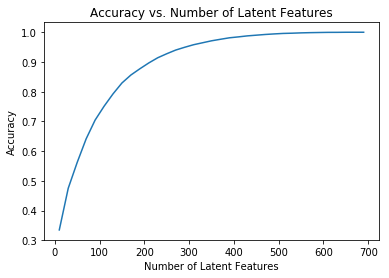

In [41]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [42]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [43]:
users_train = user_item_train.index
users_test = np.array(test_idx)
art_train = user_item_train.columns
art_test = np.array(test_arts)

missing_users_in_train = np.setdiff1d(users_test, users_train).shape[0]
total_users_test = users_test.shape[0]
total_users_train = users_train.shape[0]
test_users_in_train = total_users_test - missing_users_in_train

missing_art_in_train = np.setdiff1d(art_test, art_train).shape[0]
total_art_test = art_test.shape[0]
total_art_train = art_train.shape[0]
test_art_in_train = total_art_test - missing_art_in_train

print('{} test users are in the training set'.format(test_users_in_train))
print('{} test users are not in the training set'.format(missing_users_in_train))
print('{} test articles are in the training set'.format(test_art_in_train))
print('{} test articles are not in the training set'.format(missing_art_in_train))

20 test users are in the training set
662 test users are not in the training set
574 test articles are in the training set
0 test articles are not in the training set


In [44]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [45]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [46]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [47]:
users_we_can_predict = user_item_train.index[user_item_train.index.isin(test_idx)]
art_we_can_predict = user_item_train.columns[user_item_train.columns.isin(test_arts)]

In [48]:
u_train = pd.DataFrame(u_train, index=user_item_train.index).loc[users_we_can_predict,:713].values
vt_train = pd.DataFrame(vt_train, columns=user_item_train.columns).loc[:,art_we_can_predict].values

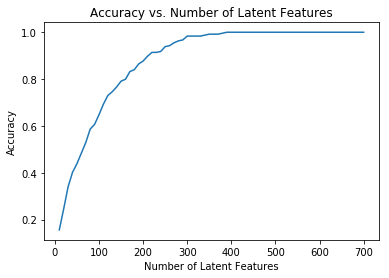

In [49]:
num_latent_feats = np.arange(10,700+10,10)
sum_errs = []
user_item_test_subset = user_item_train.loc[users_we_can_predict, art_we_can_predict]
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_pred = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_pred)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
N = user_item_test_subset.sum().sum()
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/N);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

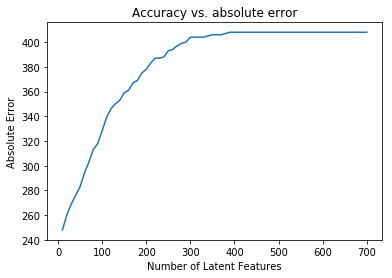

In [50]:
num_latent_feats = np.arange(10,700+10,10)
sum_errs = []
user_item_test_subset = user_item_test.loc[users_we_can_predict, art_we_can_predict]
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_pred = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_pred)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
   
plt.plot(num_latent_feats, sum_errs);
plt.xlabel('Number of Latent Features');
plt.ylabel('Absolute Error');
plt.title('Accuracy vs. absolute error');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

As we can see from the plot above, the error increases with the number of features. The more features we add the closer the result to our training data. It also stands to reason that our training data will not be a very good set to predict the test data since the articles seen in the past will not be seen again. 

To determine if our recommendations are an improvement we could roll them out and follow KPIs, like number of views or number of events or any other data about the usage that we want to improve with the recommendator. We could also roll out the recommendator on some of the users and perform an A/B test to determine if users that were given the recommendator increase the number of read articles.

Alternatively we can perform an offline method. We divide, as we did in question `4`, into training and testing data sets and we evaluate our recommendator on the test data. However this might prove difficult since there are very few users that are both on the training and test set.

Finally, we could survey our users so that they rate the recommendations. Something in the lines of "Did you find this recommendation useful?". 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0